Antonia Sanhueza

# HW 6

Dataset description:

PCE: Personal consumptions expenditures is the primary measure of consumer spending on goods and services in the US economy. This accounts for 2/3 of domestic spending and this is the primary engine that drives future economic growth https://www.bea.gov/resources/methodologies/nipa-handbook/pdf/chapter-05.pdf (Links to an external site.)

AHE: Average hourly earnings is reported in dollars per hour and is reported monthly

PCEPI Personal consumptions expenditures price index is a measure of the average increase in prices for all domestic personal consumption. A major inflationary measure in the United States

## Part 1 – 20 pts Exploratory Data Analysis

### A. 10 pts Perform quantitative and qualitative EDA

In [1]:
! pip install sktime

You should consider upgrading via the 'C:\Users\guill\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
! pip install pmdarima

You should consider upgrading via the 'C:\Users\guill\anaconda3\python.exe -m pip install --upgrade pip' command.


In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
from sktime.forecasting.all import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError, MeanAbsoluteError, MeanSquaredError
from sklearn.metrics import mean_squared_error
import seaborn as sns
import numpy as np
import statsmodels.api as sm

In [4]:
df = pd.read_csv("hw6_data_var.csv", parse_dates=["Unnamed: 0"]).rename(columns={"Unnamed: 0":"ds"})
df.set_index('ds', inplace=True)
df

,PCE,AHE,PCEPI
ds,,,
2006-03-01,9122.1,20.04,88.473
2006-04-01,9174.8,20.17,88.850
2006-05-01,9215.1,20.13,89.070
2006-06-01,9240.8,20.22,89.285
2006-07-01,9322.6,20.30,89.601
...,...,...,...
2019-08-01,14650.9,28.16,110.115
2019-09-01,14673.2,28.15,110.167
2019-10-01,14728.5,28.24,110.377


In [5]:
df.isnull().sum()

PCE      0
AHE      0
PCEPI    0
dtype: int64

In [6]:
print('Start date:', df.index.min())
print('End date:', df.index.max())
df.agg(
    {
        "PCE": ["min", "max", "median", "mean", "std"],
        "AHE": ["min", "max", "median", "mean", "std"],
        "PCEPI": ["min", "max", "median", "mean", "std"],
    }
)

Start date: 2006-03-01 00:00:00
End date: 2019-12-01 00:00:00


,PCE,AHE,PCEPI
min,9122.100000,20.040000,88.473000
max,14796.300000,28.360000,110.750000
median,11204.100000,23.765000,100.861000
mean,11507.872289,23.938193,100.006169
std,1630.579647,2.235573,6.028324


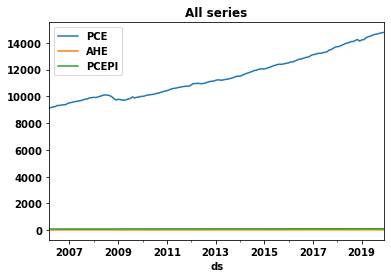

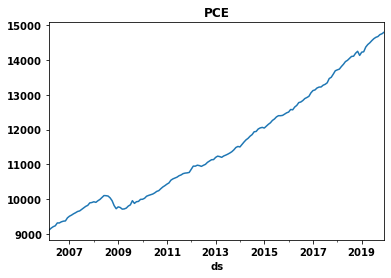

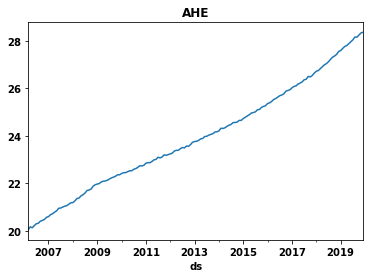

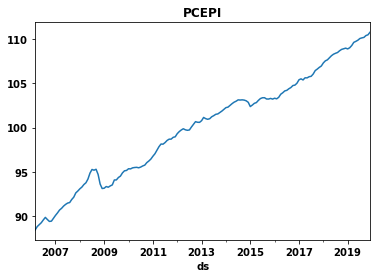

In [7]:
df.plot()
plt.title('All series')
plt.show()

df['PCE'].dropna().plot()
plt.title('PCE')
plt.show()

df['AHE'].plot()
plt.title('AHE')
plt.show()

df['PCEPI'].plot()
plt.title('PCEPI')
plt.show()

In [8]:
df.corr()

,PCE,AHE,PCEPI
PCE,1.000000,0.988292,0.973768
AHE,0.988292,1.000000,0.988329
PCEPI,0.973768,0.988329,1.000000


In [9]:
def adf_kpss_test(df_col, alpha=0.05, reg='ct'):
    '''
    Return tuple of booleans indicating if
    ADF and KPSS were passed
    Input:
    - df_col: dataframe column
    - alpha: level of confidence for test
    Output:
    adf, kpss: tuple of booleans
    '''
    adf_results = adfuller(df_col)
    adf_pval = adf_results[1]
    adf_bool = adf_pval <= alpha

    kpss_results = kpss(df_col, regression=reg)
    kpss_pval = kpss_results[1]
    kpss_bool = kpss_pval >= alpha
    
    return adf_bool, adf_pval, kpss_bool, kpss_pval

In [10]:
for col in ['PCE', 'AHE', 'PCEPI']:
    adf_bool, adf_pval, kpss_bool, kpss_pval = adf_kpss_test(df[col].dropna())
    print(col)
    print('\t - ADF pval', adf_pval)
    print('\t - ADF Stationarity test:', adf_bool)
    print('\t - KPSS pval', kpss_pval)
    print('\t - KPSS Stationarity test:', kpss_bool)

PCE
	 - ADF pval 0.9988740824722805
	 - ADF Stationarity test: False
	 - KPSS pval 0.01
	 - KPSS Stationarity test: False
AHE
	 - ADF pval 0.9980788747908695
	 - ADF Stationarity test: False
	 - KPSS pval 0.01
	 - KPSS Stationarity test: False
PCEPI
	 - ADF pval 0.9042386307188914
	 - ADF Stationarity test: False
	 - KPSS pval 0.1
	 - KPSS Stationarity test: True


C:\Users\guill\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\guill\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\guill\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


### B. 10 pts Give a summary of your findings

We can see we have the same data observations for the three series. The three series have an upward trend during the period, however they have different scales. We can see in the summary statistics table that the range of PCE is between 9,122 and 14,796, with median and mean around 11,000; the AHE ranges between 20 and 28, with median and mean around 24; the PCEPI ranges between 88 and 110, with median and mean around 100. The latter makes sense since PCEPI is a price index.

The three series are highly correlated. The correlation between PCE and AHE is 0.99, the correlation between PCE and PCEPI is 0.97, and the correlation between AHE and PCEPI is 0.99. Hence, the series move in an extremely similar way. 

None of the series are stationary according to ADF and KPSS tests. Thus, we will have to difference them in order to make forecasts.

## Part 2 – 40 pts Granger Causality

### A. 8 pts Consider PCE and AHE, give an intuitive description of the relationship between the two economic measures. This is your opinion, looking for logic and understanding not right or wrong

We saw in the EDA that there is a high positive correlation, almost 1 to 1, of AHE and PCE. In my opinion the Average Hourly Earnings impacts the Personal Consumption Expenditures. We would expect that with more earnings (increase in AHE), workers/households would be able to spend more money (increase in PCE), and viceversa. Thus the direction of the causality would be from AHE to PCE.

### B. 8 pts Difference the two variables

In [11]:
df['PCE_diff'] = df['PCE'].diff()
df['AHE_diff'] = df['AHE'].diff()
df['PCEPI_diff'] = df['PCEPI'].diff()

### C. 8 pts Check Granger Causality for the direction you stated in 2A, return plot of results

In [12]:
def plot_Granger(granger_results, alpha=0.05):
    res_list = []
    for lag, v in granger_results.items():
        res = {}
        res['Lag'] = lag
        for test, stats in v[0].items():
            res[test] = stats[1]

        res_list.append(res)

    pvals = pd.DataFrame(res_list)
    pvals.set_index('Lag', inplace=True)
    pvals_graph = pvals['params_ftest']

    pvals_graph.plot(title='Granger Causality Test')
    alpha_ser = pd.Series([alpha]*len(pvals_graph), index=pvals_graph.index)
    alpha_ser.plot(color='red')
    plt.ylabel('p-value')
    plt.show()

In [28]:
from statsmodels.tsa.stattools import grangercausalitytests, q_stat

data = df[['PCE_diff', 'AHE_diff' ]].dropna()
data


,PCE_diff,AHE_diff
ds,,
2006-04-01,52.7,0.13
2006-05-01,40.3,-0.04
2006-06-01,25.7,0.09
2006-07-01,81.8,0.08
2006-08-01,-0.8,0.02
...,...,...
2019-08-01,39.0,0.12
2019-09-01,22.3,-0.01
2019-10-01,55.3,0.09


In [ ]:
granger_results = grangercausalitytests(data, maxlag=10, verbose=True)

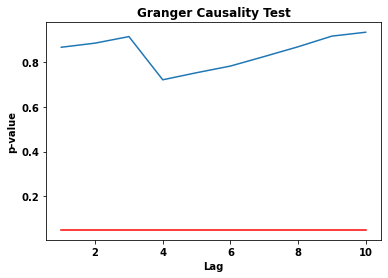

In [14]:
plot_Granger(granger_results)

The p-values are always above 0.05. Hence, we don't reject the null hypothesis.

### D. 8 pts Check Granger Causality for the opposite direction you stated in 2A, return plot of results

In [15]:
data2 = df[['AHE_diff', 'PCE_diff']].dropna()
granger_results2 = grangercausalitytests(data2, maxlag=20, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0186  , p=0.8917  , df_denom=161, df_num=1
ssr based chi2 test:   chi2=0.0189  , p=0.8906  , df=1
likelihood ratio test: chi2=0.0189  , p=0.8906  , df=1
parameter F test:         F=0.0186  , p=0.8917  , df_denom=161, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1373  , p=0.3233  , df_denom=158, df_num=2
ssr based chi2 test:   chi2=2.3466  , p=0.3094  , df=2
likelihood ratio test: chi2=2.3298  , p=0.3119  , df=2
parameter F test:         F=1.1373  , p=0.3233  , df_denom=158, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7396  , p=0.1612  , df_denom=155, df_num=3
ssr based chi2 test:   chi2=5.4546  , p=0.1414  , df=3
likelihood ratio test: chi2=5.3648  , p=0.1470  , df=3
parameter F test:         F=1.7396  , p=0.1612  , df_denom=155, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7223  , p=0.1479  

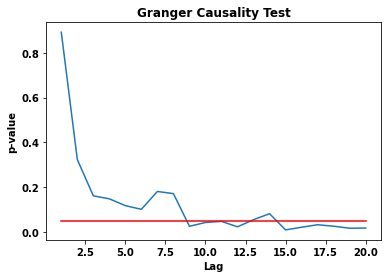

In [16]:
plot_Granger(granger_results2, 0.05)

### E. 8 pts Summarize your findings. You must understand the underlying null hypothesis of test

The null hypothesis of the Granger Test is that the lagged values of the explanatory variable (x(t)) do not explain the variation in the explained variable (y(t)). 

In the first case, where AHE caused PCE we see all the pvalues are far away from the 0.05 cutoff until the 10th lag. Hence, we don't reject the null hypothesis of no causal relationship. Hence, we don't find evidence that AHE causes PCE. 

In the second case, we explore if PCE causes AHE. In this case the pvalues decrease with the number of lags, and from the 9th lag they appear to be slightly significant. There seems to be a delay of the impact of AHE over PCE. If we take the definition of product, consumption increases product. The phenomenom we observe could be analogous to that in the sense that increasing consumption, increases sales, increasing firms profits, ultimately increasing workers earnings (AHE) in the medium/long run.

## Part 3 – 40 pts VARMA modeling

### A. 8 pts Using differenced data, run a search to find the best fit order for AH, PCE, and PCEIP, return a plot

In [17]:
# First check stationarity
for col in ['PCE_diff', 'AHE_diff', 'PCEPI_diff']:
    adf_bool, adf_pval, kpss_bool, kpss_pval = adf_kpss_test(df[col].dropna(), alpha=0.01, reg='c')
    print(col)
    print('\t - ADF pval', adf_pval)
    print('\t - ADF Stationarity test:', adf_bool)
    print('\t - KPSS pval', kpss_pval)
    print('\t - KPSS Stationarity test:', kpss_bool)

PCE_diff
	 - ADF pval 6.564987669533085e-09
	 - ADF Stationarity test: True
	 - KPSS pval 0.04451814942878118
	 - KPSS Stationarity test: True
AHE_diff
	 - ADF pval 0.7487607125683734
	 - ADF Stationarity test: False
	 - KPSS pval 0.05292964079937827
	 - KPSS Stationarity test: True
PCEPI_diff
	 - ADF pval 4.0994509674372776e-11
	 - ADF Stationarity test: True
	 - KPSS pval 0.1
	 - KPSS Stationarity test: True


C:\Users\guill\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


AHE is difference stationary, so we should take a second difference.

In [18]:
df['AHE_diff2'] = df['AHE'].diff().diff()
adf_bool, adf_pval, kpss_bool, kpss_pval = adf_kpss_test(df['AHE_diff2'].dropna(), alpha=0.01, reg='c')
print(col)
print('\t - ADF pval', adf_pval)
print('\t - ADF Stationarity test:', adf_bool)
print('\t - KPSS pval', kpss_pval)
print('\t - KPSS Stationarity test:', kpss_bool)

PCEPI_diff
	 - ADF pval 4.274243730471077e-06
	 - ADF Stationarity test: True
	 - KPSS pval 0.1
	 - KPSS Stationarity test: True


C:\Users\guill\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Now we have 3 stationary series.

In [19]:
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

In [20]:
# VARMAX automatically enforces stationarity
varma_df = df[['PCE','AHE', 'PCEPI']].dropna()
# I run into a decomposition error so I used 13 periods instead of 12 in VARMA
train = varma_df[:-13]
test = varma_df[-13:]

var_df = df[['PCE_diff','AHE_diff2', 'PCEPI_diff']].dropna()
train_var = var_df[:-12]
test_var = var_df[-12:]

prange = range(0,4)
qrange = range(1,4)

max_aic = np.inf
best_order = None

print('Running search of VARMA')
for p in prange:
    for q in qrange:
        order = (p, q)
        varma_model = VARMAX(train, order=order).fit(disp=False)
        current_aic = varma_model.aic
        print('\t Order is', order, 'with AIC of', current_aic)
        if current_aic < max_aic:
            max_aic = current_aic 
            best_order = order

print('Best VARMA order is', best_order, 'with AIC of', max_aic)

max_aic_var = np.inf
best_order_var = None
print('Running search of VAR')
for p in prange:
    order = (p, 0)
    var_model = VAR(train).fit(p)
    current_aic = var_model.aic
    print('\t Order is', order, 'with AIC of', current_aic)
    if current_aic < max_aic_var:
        max_aic_var = current_aic 
        best_order_var = order

print('Best VAR order is', best_order_var, 'with AIC of', max_aic_var)


Running search of VARMA
	 Order is (0, 1) with AIC of 2979.350418228753
	 Order is (0, 2) with AIC of 2819.0934531058083
	 Order is (0, 3) with AIC of 2742.530256952685
	 Order is (1, 1) with AIC of 4134.1471965117835
	 Order is (1, 2) with AIC of 3299.7086685803542
	 Order is (1, 3) with AIC of 2957.048379272
	 Order is (2, 1) with AIC of 6651.8173717998125
	 Order is (2, 2) with AIC of 5300.240365204367
	 Order is (2, 3) with AIC of 5432.601010813803
	 Order is (3, 1) with AIC of 7410.405155283706
	 Order is (3, 2) with AIC of 3900.275660444901
	 Order is (3, 3) with AIC of 4071.669154725519
Best VARMA order is (0, 3) with AIC of 2742.530256952685
Running search of VAR
	 Order is (0, 0) with AIC of 12.243589209130015
	 Order is (1, 0) with AIC of -3.318112474025692
	 Order is (2, 0) with AIC of -3.8363653797902275
	 Order is (3, 0) with AIC of -3.958260862334076
Best VAR order is (3, 0) with AIC of -3.958260862334076


We can see that in fact the VAR model performs much better than VARMA. So optimal order (p, q) is (3, 0).

### B. 8 pts Fit the VAR model with chosen order, return the model summary

In [21]:
var_model = VAR(train_var).fit(3)
var_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 20, May, 2022
Time:                     18:02:03
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -2.73904
Nobs:                     149.000    HQIC:                  -3.09813
Log likelihood:          -355.148    FPE:                  0.0353219
AIC:                     -3.34386    Det(Omega_mle):       0.0290677
--------------------------------------------------------------------
Results for equation PCE_diff
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                18.914994         4.921232            3.844           0.000
L1.PCE_diff           0.091985         0.101851            0.903           0.366
L1.AHE_diff2         66.729666        97.989204          

### C. 8 pts Explain the values in the correlation matrix of residuals. What are the implications for the model fit?

We expect a correlation matrix with 1's in the diagonal and 0's everywhere else. That means that the errors correlate within a series, but not across series. In this case, the ones are in the diagonal, and the other correlations are close to zero, except for PCE and PCEPI. This would be expected since the index is built on the variable. The following test checks if the correlation is significant.

In [22]:
var_model.test_whiteness(signif =0.01).summary()

Test statistic,Critical value,p-value,df
86.18,92.01,0.028,63


The null hypothesis is that there is no autocorrelation of the errors up to the 10th lag. In this case the p-value is 0.028, we reject the hypothesis at the 5% level (there is likely autocorrelation), and don't reject it at the 1% significance level (there is no autocorrelation).

### 8 pts Create 12 periods of forecast for all three variables, return plots of predicted values against actual values, Return variable level RMSE (3 total)

In [23]:
yhat = var_model.forecast(var_model.endog, steps=12)
idx=test_var.index
df_preds = pd.DataFrame(yhat).set_index(idx)
df_preds.rename(columns={0: 'PCE_forecast', 1: 'AHE_forecast', 2: 'PCEPI_forecast'}, inplace=True)

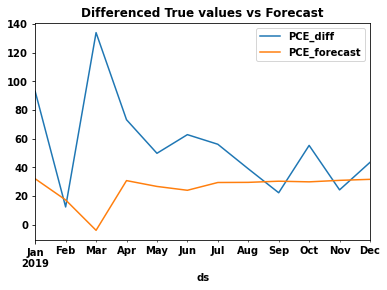

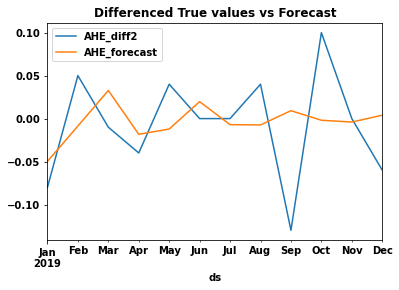

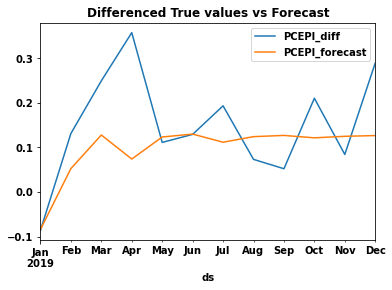

In [24]:
df_results = pd.concat([test_var, df_preds], axis=1)
df_results[['PCE_diff', 'PCE_forecast']].plot()
plt.title('Differenced True values vs Forecast')

df_results[['AHE_diff2', 'AHE_forecast']].plot()
plt.title('Differenced True values vs Forecast')
plt.show()

df_results[['PCEPI_diff', 'PCEPI_forecast']].plot()
plt.title('Differenced True values vs Forecast')
plt.show()


Now we do cumulative sum to get predictions of values, instead of predicted difference.

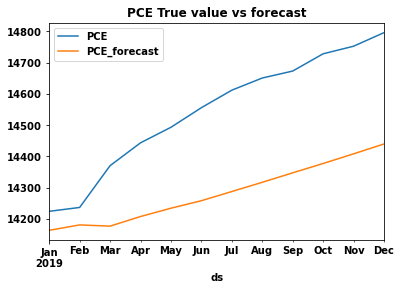

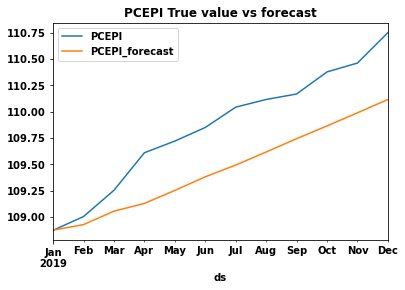

In [25]:
df_preds.rename(columns={'PCE_forecast':'PCE', 
                         'AHE_forecast': 'AHE',
                         'PCEPI_forecast': 'PCEPI'}, inplace=True)

forecast_results1 = pd.concat([df[-13:-12][['PCE', 'PCEPI']], df_preds[['PCE', 'PCEPI']]], axis=0).reset_index(drop=True)\
                    .cumsum()\
                    .drop([0])\
                    .set_index(idx)

forecast_results1.columns = ['PCE_forecast', 'PCEPI_forecast']

forecast_pce = pd.concat([df[-12:]['PCE'],forecast_results1[['PCE_forecast']]], axis=1)
forecast_pce.plot()
plt.title('PCE True value vs forecast')
plt.show()

forecast_pcepi = pd.concat([df[-12:]['PCEPI'],forecast_results1[['PCEPI_forecast']]], axis=1)
forecast_pcepi.plot()
plt.title('PCEPI True value vs forecast')
plt.show()

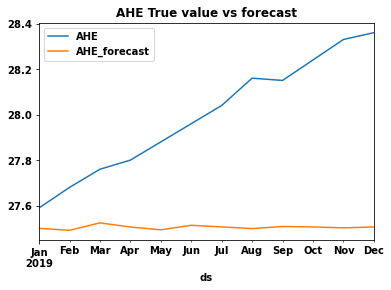

In [26]:
# AHE second difference - double cumsum
forecast_results2 = pd.concat([df[-13:-12][['AHE']],df_preds[['AHE']]], axis=0).reset_index(drop=True)\
                    .cumsum()\
                    .drop([0])\
                    .set_index(idx)

forecast_results2.columns=['AHE_forecast']

forecast_ahe = pd.concat([df[-12:]['AHE'],forecast_results2[['AHE_forecast']]], axis=1)
forecast_ahe.plot()
plt.title('AHE True value vs forecast')
plt.show()

In [27]:
print('VAR PCE RMSE: ' + str(sqrt(mean_squared_error(df[-12:]['PCE'],forecast_results1['PCE_forecast']))))
print('VAR AHE RMSE: ' + str(sqrt(mean_squared_error(df[-12:]['AHE'],forecast_results2['AHE_forecast']))))
print('VAR PCEPI RMSE: ' + str(sqrt(mean_squared_error(df[-12:]['PCEPI'],forecast_results1['PCEPI_forecast']))))

VAR PCE RMSE: 281.3213536402797
VAR AHE RMSE: 0.5491666288851634
VAR PCEPI RMSE: 0.44149511449819834


### E. 8 pts What is the advantage of this VAR model? What would ARIMA or prophet models on this dataset look like, if we were asked to forecast AHE?

Assuming the dependent variable comes from a multivarate Gaussian generation process, the VAR model has the advantage of capturing bidirectional relationships between variables, and we can estimate the series simultanously compared to ARIMA or Prophet.

ARIMA and Prophet allowed us to incorporate exogenous variables. However, VARMA allows us to incorporate the lags of the regressors as well, which ultimately is what captures the relationship between the different series.